In [5]:
#Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

#visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm


#tf libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
# System libraries
from pathlib import Path
import os.path
import zipfile
from google.colab import drive
# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
zip_path = '/content/drive/MyDrive/Capstone/skin_disease.zip'
extract_path = '/content/drive/MyDrive/Capstone'

In [8]:

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the contents
print("Files extracted to:", extract_path)

Files extracted to: /content/drive/MyDrive/Capstone


In [9]:
#helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-05-29 05:17:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-05-29 05:17:38 (14.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [10]:
skin_disease_dataset = '/content/drive/MyDrive/Capstone/skin_disease'
walk_through_dir(skin_disease_dataset)

There are 15 directories and 0 images in '/content/drive/MyDrive/Capstone/skin_disease'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Capstone/skin_disease/acne'.
There are 0 directories and 102 images in '/content/drive/MyDrive/Capstone/skin_disease/atopic_dermatitis'.
There are 0 directories and 271 images in '/content/drive/MyDrive/Capstone/skin_disease/basal_cell_carcinoma'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Capstone/skin_disease/benign_keratosis_like_lesions'.
There are 0 directories and 170 images in '/content/drive/MyDrive/Capstone/skin_disease/chicken_pox'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Capstone/skin_disease/eksim'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Capstone/skin_disease/melanoctyic_nevi'.
There are 0 directories and 247 images in '/content/drive/MyDrive/Capstone/skin_disease/melanoma'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Capston

In [11]:
img_directory = Path(skin_disease_dataset)
filepaths = list(img_directory.glob(r'**/*.JPG')) + list(img_directory.glob(r'**/*.jpg')) + list(img_directory.glob(r'**/*.png')) + list(img_directory.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [12]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/Capstone/skin_disease/a...,atopic_dermatitis
1,/content/drive/MyDrive/Capstone/skin_disease/a...,atopic_dermatitis
2,/content/drive/MyDrive/Capstone/skin_disease/a...,atopic_dermatitis
3,/content/drive/MyDrive/Capstone/skin_disease/a...,atopic_dermatitis
4,/content/drive/MyDrive/Capstone/skin_disease/a...,atopic_dermatitis
...,...,...
2425,/content/drive/MyDrive/Capstone/skin_disease/u...,urticaria_hives
2426,/content/drive/MyDrive/Capstone/skin_disease/u...,urticaria_hives
2427,/content/drive/MyDrive/Capstone/skin_disease/u...,urticaria_hives
2428,/content/drive/MyDrive/Capstone/skin_disease/u...,urticaria_hives


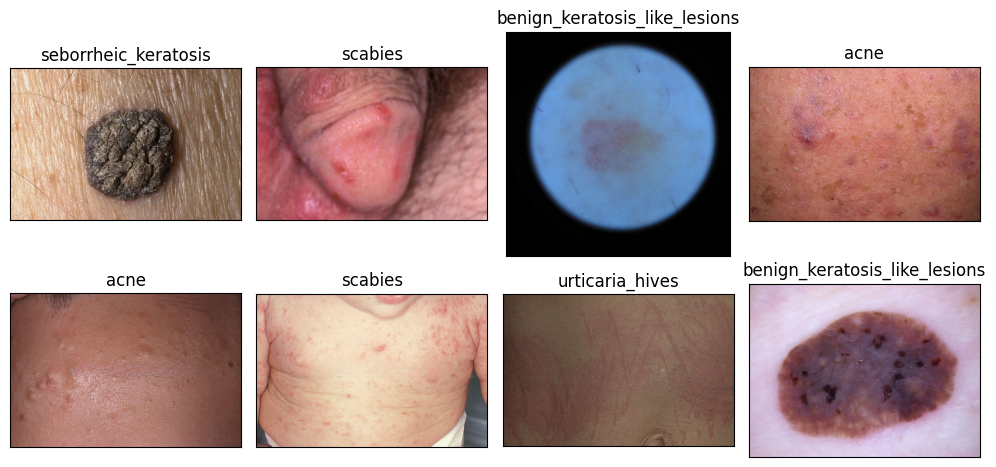

In [13]:
# Display 8 pictures of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 8)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = plt.imread(image_df['Filepath'].iloc[random_index[i]])
    ax.imshow(img)
    ax.set_title(image_df['Label'].iloc[random_index[i]])

plt.tight_layout()
plt.show()

In [14]:
#separate to training, validation, testing
training_dataset, testing_dataset = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [15]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [16]:
training_images = train_generator.flow_from_dataframe(
dataframe = training_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=42,
subset='training')

validation_images = train_generator.flow_from_dataframe(
dataframe = training_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=42,
subset='validation')

test_images = test_generator.flow_from_dataframe(
dataframe = testing_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=False)

Found 1556 validated image filenames belonging to 15 classes.
Found 388 validated image filenames belonging to 15 classes.
Found 486 validated image filenames belonging to 15 classes.


In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1./255),
])

augmented = keras.Sequential([
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomZoom(0.3),
    preprocessing.RandomRotation(0.4),
    preprocessing.RandomWidth(0.3),
    preprocessing.RandomHeight(0.3)
], name="data_augmentation")

In [18]:
input_shape = (224,224,3)
Base_Model = tf.keras.applications.MobileNetV3Large(
input_shape=input_shape,
include_top = False,
    weights = 'imagenet',
    pooling='avg'
)
Base_Model.trainable = False

12683000/12683000 [==============================] - 0s 0us/step


In [19]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=5,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

In [22]:
def build_model(base_model, num_classes):
    input = base_model.input
    x = Dense(256, activation='relu')(base_model.output)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input, outputs=outputs)
    return model

# Assuming your dataset has 15 classes
num_classes = 15

# Replace `Base_Model` with your actual base model instance
Base_Model = tf.keras.applications.MobileNetV3Small(include_top=False, pooling='avg')

# Build the model with the correct number of classes
model = build_model(Base_Model, num_classes)
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Assuming you have already defined `training_images`, `validation_images`, `early_stopping`, and `create_tensorboard_callback`
history = model.fit(
    training_images,
    steps_per_epoch=len(training_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", "skin_disease_classification")
    ]
)

4334752/4334752 [==============================] - 0s 0us/step
Saving TensorBoard log files to: training_logs/skin_disease_classification/20240529-052320
Epoch 1/100
49/49 [==============================] - 87s 728ms/step - loss: 2.8019 - accuracy: 0.0797 - val_loss: 2.6664 - val_accuracy: 0.0928
Epoch 2/100
49/49 [==============================] - 26s 531ms/step - loss: 2.6321 - accuracy: 0.1150 - val_loss: 2.6272 - val_accuracy: 0.1469
Epoch 3/100
49/49 [==============================] - 30s 626ms/step - loss: 2.5428 - accuracy: 0.1600 - val_loss: 2.5476 - val_accuracy: 0.1985
Epoch 4/100
49/49 [==============================] - 25s 519ms/step - loss: 2.4505 - accuracy: 0.1934 - val_loss: 2.4442 - val_accuracy: 0.2526
Epoch 5/100
49/49 [==============================] - 25s 510ms/step - loss: 2.3392 - accuracy: 0.2333 - val_loss: 2.3283 - val_accuracy: 0.2912
Epoch 6/100
49/49 [==============================] - 25s 513ms/step - loss: 2.2110 - accuracy: 0.2841 - val_loss: 2.1962 - val

In [23]:
results = model.evaluate(test_images, verbose=2)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

16/16 - 7s - loss: 0.7575 - accuracy: 0.8148 - 7s/epoch - 415ms/step
    Test Loss: 0.75746
Test Accuracy: 81.48%


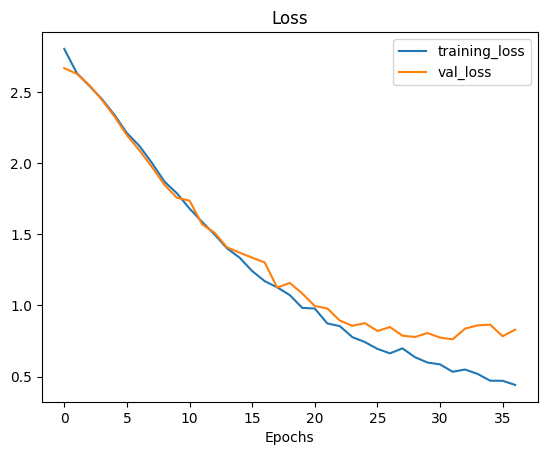

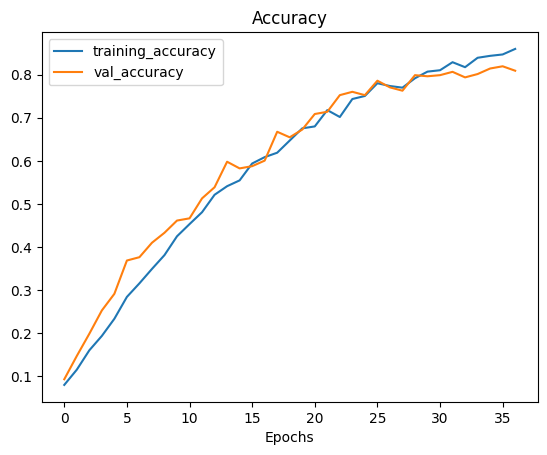

In [24]:
plot_loss_curves(history)

In [25]:
model.save('train_model_mobileNetV3_tes.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
 converter = tf.lite.TFLiteConverter.from_keras_model(model)
 tflite_model = converter.convert()

 with open('model.tflite_2', 'wb') as f:
   f.write(tflite_model)

In [27]:
history.history #Return Dictionary of history

{'loss': [2.8019003868103027,
  2.632124185562134,
  2.542808771133423,
  2.450463056564331,
  2.339164972305298,
  2.2110354900360107,
  2.1205251216888428,
  2.0011448860168457,
  1.8699712753295898,
  1.7870969772338867,
  1.6808334589004517,
  1.5876002311706543,
  1.498613953590393,
  1.4012367725372314,
  1.3356592655181885,
  1.2421196699142456,
  1.1710885763168335,
  1.1273036003112793,
  1.07325279712677,
  0.9832273125648499,
  0.9786643981933594,
  0.8738225102424622,
  0.8552389144897461,
  0.7776660919189453,
  0.7432789206504822,
  0.6952820420265198,
  0.6636993288993835,
  0.6989465355873108,
  0.6368080377578735,
  0.5993644595146179,
  0.5862542986869812,
  0.5347273349761963,
  0.5501658916473389,
  0.5192382335662842,
  0.4716806411743164,
  0.47097793221473694,
  0.44208696484565735],
 'accuracy': [0.07969151437282562,
  0.11503855884075165,
  0.1600257009267807,
  0.19344472885131836,
  0.23329049348831177,
  0.2840617001056671,
  0.3155527114868164,
  0.34897172

In [28]:
#Recording History in json
import json
with open('train_hist_mobileNetV3_new2.json','w') as f:
  json.dump(history.history,f)

In [29]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [30]:
print("Validation set Accuracy: {} %".format(history.history['val_accuracy'][-1]*100))

Validation set Accuracy: 80.92783689498901 %


In [31]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (training_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

16/16 [==============================] - 7s 413ms/step
The first 5 predictions: ['melanoma', 'acne', 'eksim', 'eksim', 'urticaria_hives']


In [32]:
  # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(testing_dataset) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testing_dataset.Filepath.iloc[random_index[i]]))
    if testing_dataset.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {testing_dataset.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

In [33]:
y_test = list(testing_dataset.Label)
print(classification_report(y_test, pred))

                                                       precision    recall  f1-score   support

                                                 acne       0.96      0.86      0.91        50
                                    atopic_dermatitis       0.56      0.66      0.60        29
                                 basal_cell_carcinoma       0.84      0.98      0.90        52
                        benign_keratosis_like_lesions       0.80      0.62      0.70        13
                                          chicken_pox       0.95      0.97      0.96        36
                                                eksim       0.85      0.83      0.84        42
                                     melanoctyic_nevi       0.69      0.55      0.61        20
                                             melanoma       0.94      0.92      0.93        48
psoriasis_pictures_lichen_planus_and_related_diseases       1.00      0.17      0.29        12
                                             ring

In [35]:
import tensorflow as tf
import pathlib

# Specify the correct path to your model
model_path = '/content/drive/MyDrive/Capstone/train_model_mobileNetV3.h5'

# Load the Keras model
try:
    model = tf.keras.models.load_model(model_path)
except OSError as e:
    print(f"Error loading model: {e}")

# Convert the Keras model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Specify the file name and path for the TFLite model
tflite_model_file = pathlib.Path('/content/drive/MyDrive/Capstone/train_model_mobileNetV3.tflite')

# Save the TFLite model to a file
tflite_model_file.write_bytes(tflite_model)

print(f"TFLite model saved to: {tflite_model_file}")


Error loading model: No file or directory found at /content/drive/MyDrive/Capstone/train_model_mobileNetV3.h5
TFLite model saved to: /content/drive/MyDrive/Capstone/train_model_mobileNetV3.tflite
